# Investigation of the Equilibrium Paths of the Box Beam Reinforced with Ribs and Stiffeners

In our [previous notebook](15_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs.ipynb) we ascertained the existence of complimentary paths beyond the natural path for the box beam reinforced with ribs only. In this notebook we are going to perform an analogous investigation for the box beam reinforced with ribs and stiffners.

* [Setup of the numerical model](#numerical-model)
* [Verification of the existence of other equilibrium paths](#verification)
* [Visualization of 3D equilibrium diagram and of deformation shapes](#visualization)
* [Conclusions](#conclusions)

## Setup of the numerical model <a name="numerical-model"></a>

***

We consider the same box beam reinforced with ribs and stiffeners analyzed in our [twelfth notebook](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb).

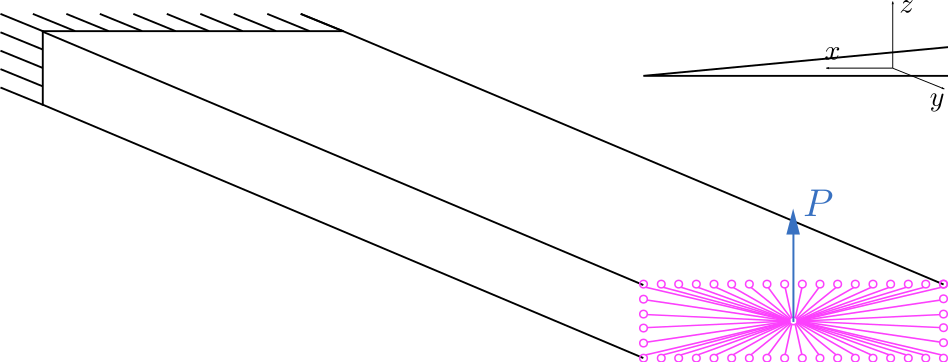

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join("resources", "08_BoxBeamConcentratedLoad.svg"))

In [2]:
import numpy as np

# Define geometry
AR = 9.   # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
l = AR*w/2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f"Box beam dimensions:\n- width: {w/1e3:.1f} m\n- length: {l/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm")

# Define ribs location
ribs_spacing = w/2  # half of box beam's width
no_ribs = int(np.ceil(l/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # calculate y-coordinates of the ribs
np.set_printoptions(precision=0)
print(f"Number of ribs: {no_ribs:.0f}")
print(f"Ribs\' y-coordinate [mm]:")
print(ribs_y_locations)

# Define location and height of stiffeners
stiffeners_spacing = ribs_spacing/1.4
no_stiffeners = int(np.ceil(w/stiffeners_spacing)) - 1
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]
stiffeners_height = h/10
print(f"Number of stiffeners: {no_stiffeners:d}")
print(f"Stiffeners x-coordinate [mm]:")
print(stiffeners_x_locations)
print(f"Stiffeners height: {stiffeners_height:.0f} mm")

# Define material
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

Box beam dimensions:
- width: 1.0 m
- length: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm
Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]
Number of stiffeners: 2
Stiffeners x-coordinate [mm]:
[333. 667.]
Stiffeners height: 20 mm


Let's define the mesh using a shell element of 49 mm, as found in a previous [mesh convergence study](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb#mesh-convergence). We use the function `mesh_stiffened_box_beam_with_pyvista` from the `box_beam_utils` module and then we call the function `create_base_bdf_input` from the same module, which generates a `BDF` object of our box beam with material properties, nodes, elements, boundary conditions and output files defaults. Finally, we print the cards of the `BDF` object.

In [3]:
from resources import box_beam_utils

shell_element_length = 49.  # [mm]
box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h,
                                                                    stiffeners_x_coordinates=stiffeners_x_locations,
                                                                    stiffeners_height=stiffeners_height, element_length=shell_element_length)
nodes_coordinates_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                    nodes_xyz_array=nodes_coordinates_array,
                                                    nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 8562

bdf.elements: 0
  CQUAD4   : 8784

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now we add a concentrated upward force at the center of the tip section, connecting with a RBE3 element the nodes on the edge of the section to a new node in the center.

In [4]:
# Add master node of tip section
tip_master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf.add_grid(tip_master_node_id, [w/2, l, 0.])

# Find id of the nodes on the edge of the tip rib
tolerance = shell_element_length/100  # geometric tolerance to find the nodes on the edge of the tip rib
tip_edge_nodes_ids = [nid for nid in box_beam_bdf.nodes if (np.abs(box_beam_bdf.nodes[nid].xyz[1] - l) < tolerance) &  # y = l
                      (np.abs((box_beam_bdf.nodes[nid].xyz[0]) < tolerance) |  # x = 0
                       (np.abs(box_beam_bdf.nodes[nid].xyz[0] - w) < tolerance) |  # x = w
                       (np.abs(box_beam_bdf.nodes[nid].xyz[2] - h/2) < tolerance) |  # z = -h/2
                       (np.abs(box_beam_bdf.nodes[nid].xyz[2] + h/2) < tolerance))]  # z = h/2

# Add RBE3 to connect master node with edge nodes of tip rib
rbe3_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe3(eid=rbe3_eid, refgrid=tip_master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids),
                      comps=['123456']*len(tip_edge_nodes_ids), Gijs=tip_edge_nodes_ids)

# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf.add_force(sid=force_set_id, node=tip_master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

FORCE         11    8563              1.      0.      0.      1.

Finally we set up the arc-length method with default parameters calling the function `set_up_arc_length_method` from the `pynastran_utils` module.

In [5]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

pynastran_utils.set_up_arc_length_method(box_beam_bdf)  # set up SOL 106 with arc-length method using default parameters

## Verification of the existence of other equilibrium paths <a name="verification"></a>

***

In a [previous sensitivity study](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb#nonlinear-analysis-parameters) of the nonlinear analysis parameters we obtained different load-displacement curves for different combination of convergence tolerances. While we previously attributed this discrepancy to the accuracy of the nonlinear solution, now we are going to investigate whether the equilibrium points actually belong to different equilibrium paths.

We are going to start with a first analysis using $EPSP=10^{-3}$ and $EPSW=10^{-7}$. We define two subcases with the following nonlinear analysis parameters:

1. concentrated tip load, $EPSP=10^{-3}, EPSW=10^{-7}$, default remaining parameters;
2. no load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$.

In the second subcase we use $\Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$ to obtain a very fine resolution of the equilibrium path while unloading the structure.

Let's recall the buckling load predicted by SOL 105 and create the two subcases.

In [6]:
# Create first subcase to load the structure
sol_105_buckling_load = 8424.  # [N]
load_set_id = force_set_id + 1  # define id of LOAD card
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[2*sol_105_buckling_load], load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set
box_beam_bdf.nlparms[1].eps_p = 1e-3  # change convergence tolerance for load function
box_beam_bdf.nlparms[1].eps_w = 1e-7  # change convergence tolerance for energy function

# Create second subcase to unload the structure
zero_load_set_id = load_set_id + 1  # id of LOAD card
box_beam_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])  # add LOAD card with zero applied load
second_subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=second_subcase_id, load_set_id=zero_load_set_id)  # create subcase with zero applied load
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, nlparm_id=second_subcase_id, eps_p=1e-3, eps_w=1e-7, ninc=100, desiter=5,
                                         maxalr=1.01, maxinc=50,
subcase_id=second_subcase_id)  # set up arc-length method for second subcase using parameters for very fine resolution of equilibrium path

Let's run the analysis by calling the function `run_tangent_stiffness_matrix_eigenvalue_calculation` from the `pynatran_utils` module, using `no_eigenvalues=10` to calculate the 10 lowest eigenvalue of the tangent stiffness matrix at each converged iteration.

In [7]:
from resources import pynastran_utils

# Define analysis directory
analysis_directory_name = "16_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs_and_Stiffeners"
analysis_directory_path = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

# Run analysis
method_set_id = zero_load_set_id + 1  # id of the EIGRL card associated to the METHOD case command
analysis_label = "2Psol105_epsp1e-3"
input_name = "path_existence_verification_" + analysis_label
no_eigenvalues = 10
sol_106_op2 = {}  # empty dictionary where we store the OP2 objects resulting from the different analyses
sol_106_op2[analysis_label] = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, analysis_directory_path=analysis_directory_path,
    input_name=input_name, no_eigenvalues=no_eigenvalues, run_flag=False)

Nastran job path_existence_verification_2Psol105_epsp1e-3.bdf completed
Wall time: 344.0 s


Analogously to our last two notebooks, we want to plot the load-displacement diagram and the eigenvalues of the tangent stiffness matrix. For this reason, we define the functions `plot_load_displacement_diagram` and `plot_tangent_stiffness_matrix_eigenvalues`. We use the first to plot the applied load against the tip displacement nondimensionalized with the length of the box beam, $u_{z, tip}/l$, and the second to plot the eigenvalues $\lambda$ of the tangent stiffness matrix against the iteration number and the applied load.

In [8]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
import matplotlib.pyplot as plt

component_index = 2  # used to select translation along the z-axis for both applied loads and displacements
markers = list(Line2D.markers.keys())[2:]  # list of marker characters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors

def plot_load_displacement_diagram(disp, loads):
    load_displacement_ax = plt.subplot()  # create figure with one subplot
    for subcase in loads:  # iterate through the subcases
        load_displacement_ax.plot(disp[subcase][:, component_index]/l, loads[subcase][:, component_index]/sol_105_buckling_load,
                                  marker=markers[subcase - 1],
                                   label=f'Subcase {subcase:d}')  # plot applied loads against displacement for each converged iteration
    load_displacement_ax.legend()  # set up legend
    plt.xlabel('$u_{z, tip}/l$')
    plt.ylabel('$P/P_\mathrm{SOL\/105}$')
    plt.grid()
    plt.show()

def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues from f06 file
    f06_path = os.path.join(directory_path, input_name + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    iterations_count = 1
    # Divide lowest eigenvalues by subcase and plot them
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase in loads:
        no_load_steps = len(loads[subcase])
        eigenvalues_by_subcase[subcase] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number in first subplot
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase].shape[1] + iterations_count),
                            eigenvalues_by_subcase[subcase].T, markers[subcase - 1],
        color=colors[subcase - 1], label=f'Subcase {subcase:d}')
        iterations_count += eigenvalues_by_subcase[subcase].shape[1]
        # Plot eigenvalues vs applied load in second subplot
        eigvals_axs[1].plot(loads[subcase][:eigenvalues_by_subcase[subcase].shape[1], component_index]/sol_105_buckling_load,
                            eigenvalues_by_subcase[subcase].T,
        markers[subcase - 1], color=colors[subcase - 1])
    # Set plot appearance
    eigvals_axs[0].set_xlabel('Iteration')
    eigvals_axs[0].set_ylabel('$\lambda$, N/mm')
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    eigvals_axs[1].grid(visible=True)
    plt.show()

Let's read the load-displacement history from the `OP2` object returned by the function `run_tangent_stiffness_matrix_eigenvalue_calculation` and plot both the load-displacement and the eigenvalue diagram.

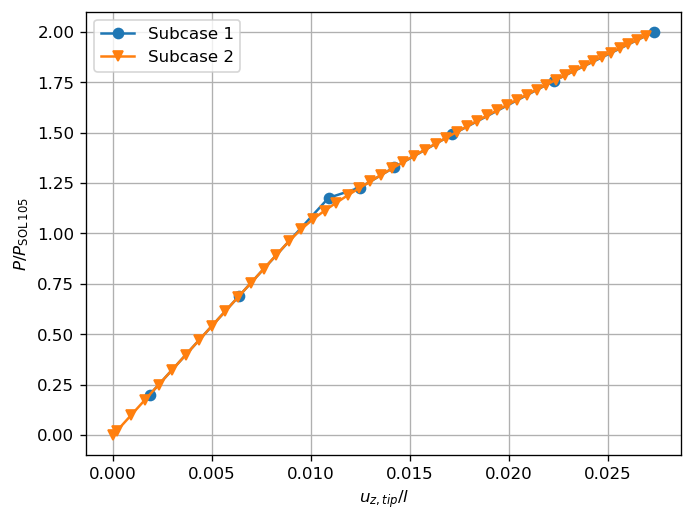

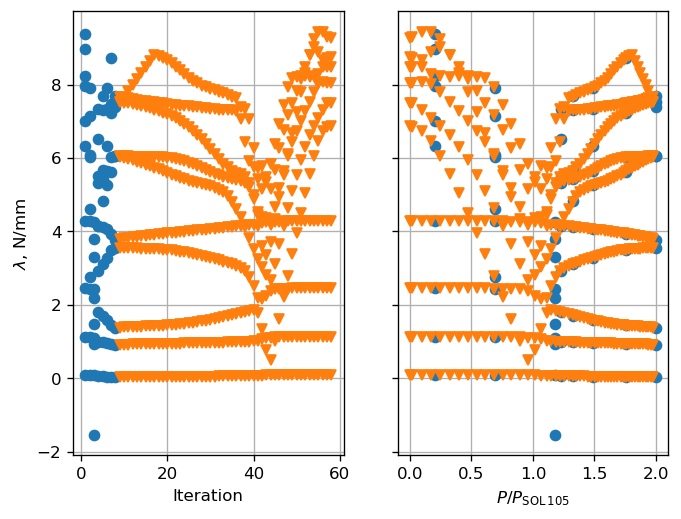

In [9]:
import matplotlib.pyplot as plt

# Set default dpi of figures
plt.rcParams['figure.dpi'] = 120

# Read load and displacement history from the op2 file
applied_loads = {}  # empty dictionary where we store the history of applied loads resulting from the different analyses
tip_displacements = {}  # empty dictionary where we store the history of tip displacements resulting from the different analyses
_, applied_loads[analysis_label], tip_displacements[analysis_label] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[analysis_label], displacement_node_id=tip_master_node_id)

# Plot results
plot_load_displacement_diagram(tip_displacements[analysis_label], applied_loads[analysis_label])
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads[analysis_label])

We can see that during the first subcase, the solver jumps to an unstable path for an applied load close to $P/P_\text{SOL 105}=1.2$ and then it seems to immediately jump back on the natural path at the following iteration. In the second subcase, the solver appears to follow the natural path while the structure is unloaded.

However, the tip displacement at the end of the first subcase is different from the one obtained in [notebook 12](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb#nonlinear-analysis-parameters) using the same parameters. Why is that? If we look at the bdf files we find out that the only difference that may have some relevance is the magnitude of the applied load. In fact, here we have applied a load $P=16848$ N, while in our previous analysis we appplied a load $P=16847.75$ N. This came by the fact that in our previous analysis we used the exact buckling load value calculated by SOL 105 to define the applied load, while here we have approximated the buckling load found by SOL 105 to $P_\text{SOL 105}=8424$ N. The difference may seem irrelevant, but we are going to test whether applying the exact same load of our previous analysis we are able to replicate the results.

For this reason, we modify the magnitude of the applied load, rerun the analysis and plot again the load-displacement and the eigenvalue diagram.

Nastran job path_existence_verification_2Psol105_epsp1e-3_modified_load.bdf completed
Wall time: 293.0 s


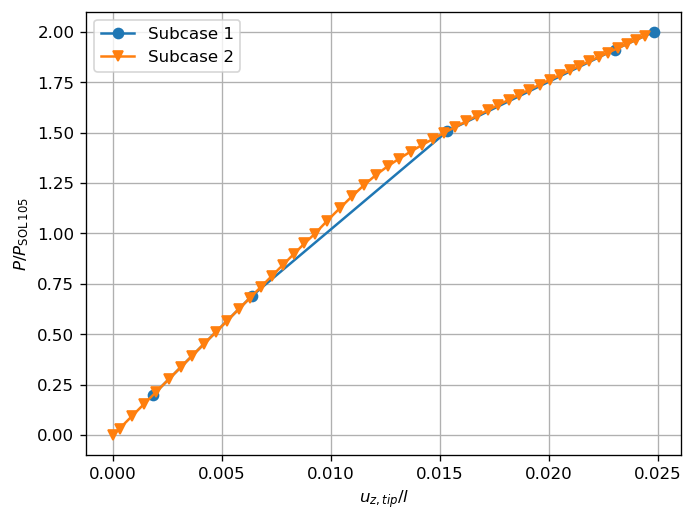

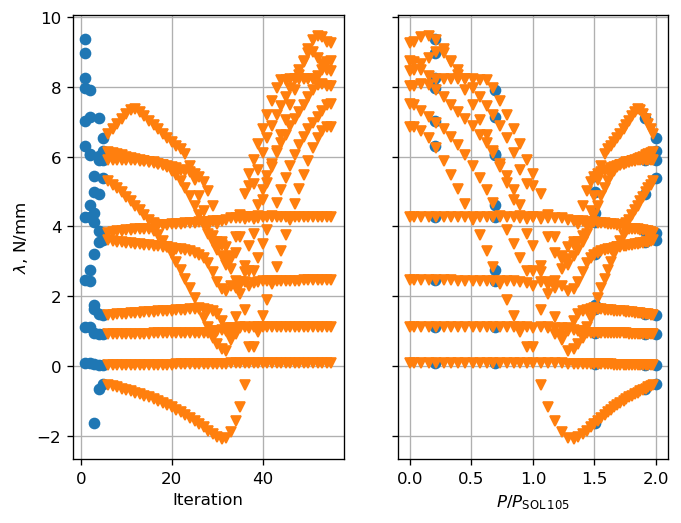

In [10]:
# Change magnitude of applied load
box_beam_bdf.load_combinations[load_set_id][0].scale_factors[0] = 16847.75  # [N]

# Run analysis
analysis_label = "2Psol105_epsp1e-3_modified_load"
input_name = "path_existence_verification_" + analysis_label
sol_106_op2[analysis_label] = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, analysis_directory_path=analysis_directory_path,
    input_name=input_name, no_eigenvalues=no_eigenvalues, run_flag=False)

# Read load and displacement history from the op2 file
_, applied_loads[analysis_label], tip_displacements[analysis_label] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[analysis_label], displacement_node_id=tip_master_node_id)

# Plot load-displacement and eigenvalue diagram
plot_load_displacement_diagram(tip_displacements[analysis_label], applied_loads[analysis_label])
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads[analysis_label])

These results appear to confirm that the small difference in applied load was indeed the cause of the mismatch between the results of our initial analysis and the ones of notebook 12. In fact, now the results of the first subcase perfectly match the results of our previous notebook. What is interesting to notice is that, while in our initial analysis the last equilibrium point of the first subcase appeared to be stable and to belong to the natural path, now the last iteration appears to have converged on a point of an unstable path. As a consequence, we observe that the combination of the present box beam configuration and of the arc-length solver settings of the first subcase appears to be very sensitive to the applied load, since a very small change results in the solver landing on two completely different equilibrium paths.

Another surprising thing is what happens in the second subcase. While we would expect the solver to fail in reaching the ground state, as it should follow a path that is disconnected from the natural path, we actually find that the structure is successfully unloaded. Why does this happen? Does the solver jump close to $P/P_\text{SOL 105}=1$ or is there a bifurcation? Let's investigate that by repeating the analysis with an even smaller arc-length size for the second subcase.

Nastran job path_existence_verification_2Psol105_epsp1e-3_modified_load_desiter2.bdf completed
Wall time: 1002.0 s


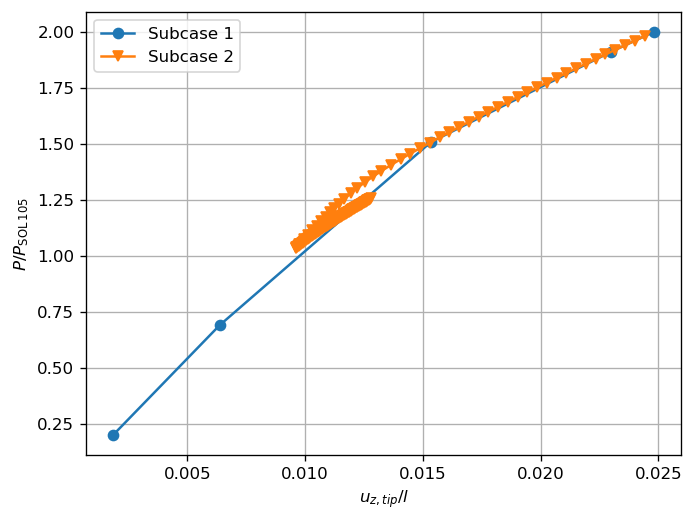

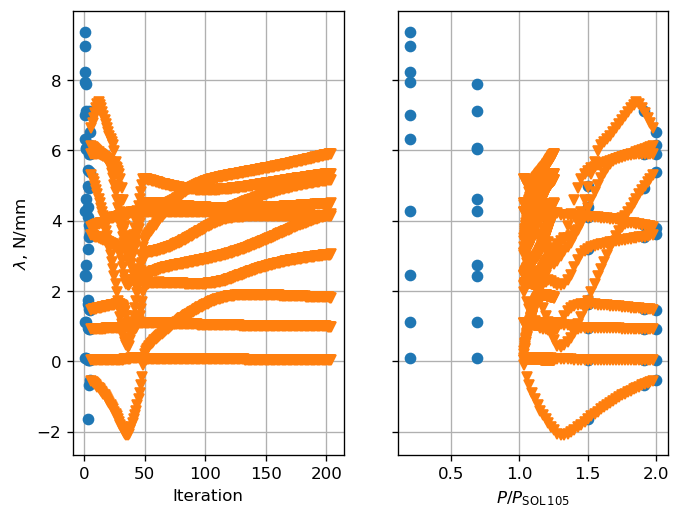

In [11]:
# Change arc-length settings to use a smaller step size
box_beam_bdf.nlpcis[second_subcase_id].desiter = 2  # reduce the number of desired iteration to prevent the arc-length size from increasing
box_beam_bdf.nlpcis[second_subcase_id].mxinc = 200  # increase the maximum number of allowed increments to prevent the analysis from stopping

# Run analysis
analysis_label = "2Psol105_epsp1e-3_modified_load_desiter2"
input_name = "path_existence_verification_" + analysis_label
sol_106_op2[analysis_label] = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)  # run analysis and read OP2 file

# Read load and displacement history from the op2 file
_, applied_loads[analysis_label], tip_displacements[analysis_label] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2[analysis_label], displacement_node_id=tip_master_node_id)

# Plot load-displacement and eigenvalue diagram
plot_load_displacement_diagram(tip_displacements[analysis_label], applied_loads[analysis_label])
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads[analysis_label])

Contrary to our previous analysis, we now observe that the arc-length solver in the second subcase does not manage to completely unload the structure, and it follows a path which seems disconnected from the ground state. This suggests that probably in the previous case, the solver jumped from a complementary path to the natural path close to $P/P_\text{SOL 105}=1$, making it resemble a bifurcation point.

However, in this case we observe something which we did not observe for the unreinforced box beam and the box beam reinforced with ribs only, that is to say that the complementary path appears to be partly unstable and partly stable. However, this feature is present for [Euler's column](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb#1dof), so it should not be considered something too unusual. 

## Visualization of 3D equilibrium diagram and deformation shapes <a name="visualization"></a>

***

To verify whether the observed path is disconnected from the natural path, we are going to visualize both paths on a 3D load-displacement diagram with the applied load plotted against the tip displacement and a local displacement. Similarly to our previous studies on the [unreinforced box beam](14_Investigation_of_the_Equilibrium_Paths_of_the_Unreinforced_Box_Beam.ipynb#visualization) and on the [box beam reinforced with ribs only](15_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs.ipynb#visualization), for the local displacement we choose the displacement $u_z$ of the node where we observe the maximum displacement in the linear buckling analysis (SOL 105).

We delete the two subcases and call the function `run_sol_105_buckling_analysis` from the `pynastran_utils` module in order to find the id of the node where the maximum displacement occurs according to the linear buckling prediction.

Nastran job path_existence_verification_sol_105.bdf completed
Wall time: 5.0 s


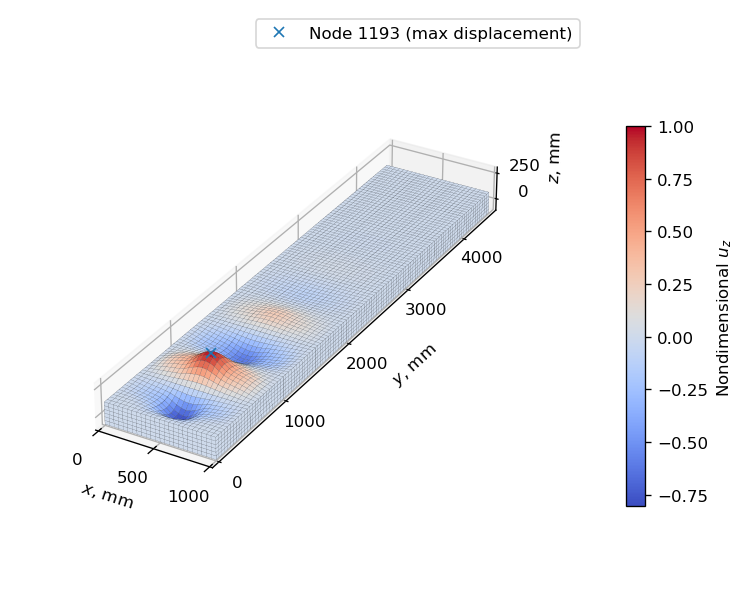

In [12]:
# Delete subcases 1 and 2
for subcase_id in range(1, 3):
    del box_beam_bdf.subcases[subcase_id]

# Run linear buckling analysis
input_name = "path_existence_verification_sol_105"
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=box_beam_bdf.__deepcopy__({}), static_load_set_id=force_set_id,
                                                            analysis_directory_path=analysis_directory_path, input_name=input_name,
                                                            run_flag=False)

# Find id of node where maximum displacement occurs
max_displacement_node_id = np.argmax(sol_105_op2.eigenvectors[second_subcase_id].data[0, :, component_index]) + 1

# Plot critical buckling mode
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=second_subcase_id, displacement_component="tz",
                                                 colormap="coolwarm")

# Plot node of max displacement
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz + 200*sol_105_op2.eigenvectors[
    second_subcase_id].data[0, max_displacement_node_id - 1, 0:3]  # we multiply the eigenvector by the default displacement scale factor of plot_buckling_mode
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], "x",
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(0, .14))  # move colorbar upwards

# Set axes ticks and labels' position and show plot
adjust_3d_plot(ax, cbar)
plt.show()

Now we need to find the vertical displacement history at node 1193, $u_{z, 1193}$, for the different equilibrium paths. Since we want to compare the results of all our three previous analyses, we look for the local displacement in each corresponding `OP2` object.

In [13]:
analysis_labels = ["2Psol105_epsp1e-3", "2Psol105_epsp1e-3_modified_load", "2Psol105_epsp1e-3_modified_load_desiter2"]
local_displacements = {}
for analysis_label in analysis_labels:
    _, _, local_displacements[analysis_label] = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=sol_106_op2[analysis_label], displacement_node_id=max_displacement_node_id)

For ease of plotting, we create new dictionaries with nondimensionalized displacements and applied loads of the second subcase of each analysis. We nondimensionalize the first with the length $l$ of the box beam and the second with the buckling load predicted by SOL 105, $P_\text{SOL 105}$.

Finally, we produce the 3D plot of the equilibrium diagram.

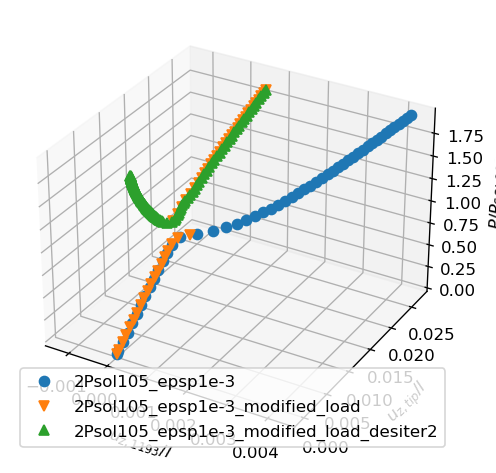

In [14]:
# Create new dictionaries with nondimensionalized quantities
nondimensional_local_displacements = {count: local_displacements[key][second_subcase_id][:, component_index]/l
                                      for count, key in enumerate(analysis_labels)}
nondimensional_tip_displacements = {count: tip_displacements[key][second_subcase_id][:, component_index]/l
                                    for count, key in enumerate(analysis_labels)}
nondimensional_applied_loads = {count: applied_loads[key][second_subcase_id][:, component_index]/sol_105_buckling_load
                                for count, key in enumerate(analysis_labels)}

# Create 3D plot of equilibrium diagram
plt.figure()
ax_3d = plt.axes(projection="3d")
for count, key in enumerate(analysis_labels):
    ax_3d.plot3D(nondimensional_local_displacements[count], nondimensional_tip_displacements[count], nondimensional_applied_loads[count],
                 markers[count], color=colors[count], label=key)

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z, {max_displacement_node_id:d}}}/l$")
ax_3d.set_ylabel("$u_{z, tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

The plot clearly shows that in the first analysis the arc-length solver moved along the natural path, in the third analysis the solver moved along a disconnected complementary path, while in the second analysis the solver jumped from the complementary path to the natural path around $P/P_\text{SOL 105}=1$. As a consequence, we conclude that there does not appear to be any bifurcation, similarly to the previous versions of the box beam.

To explore the deformation shape on the natural and on the complementary path, we cut the plot with a plane at $P/P_\text{SOL 105}=1.25$ and plot the deformation shape at the closest point to each of the intersections.

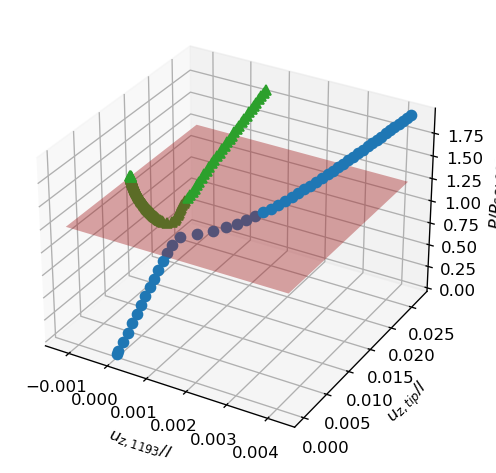

Deformation on natural path:


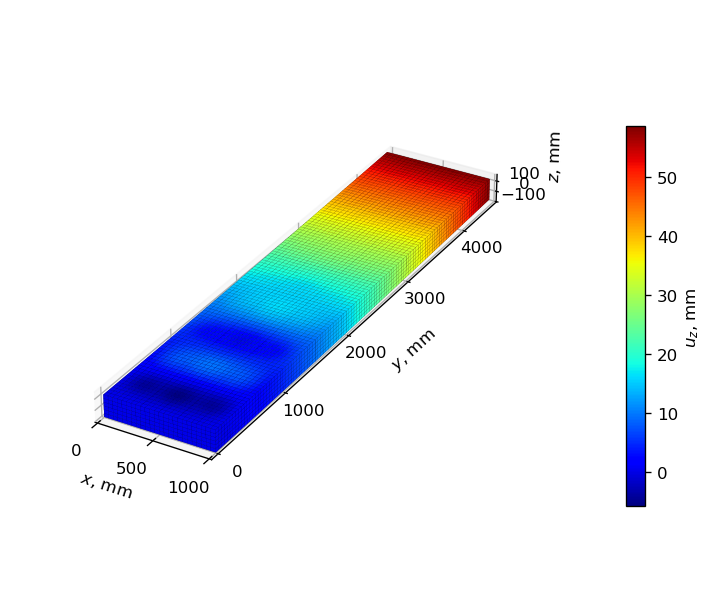

Deformations on unstable path:


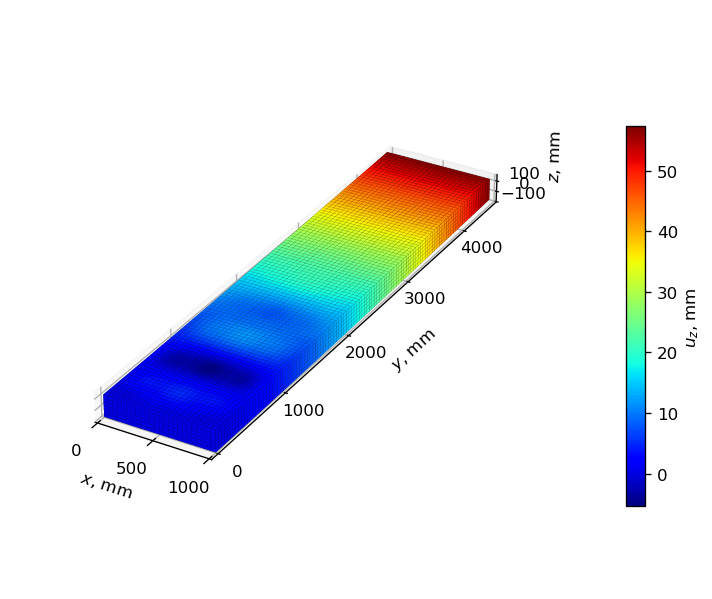

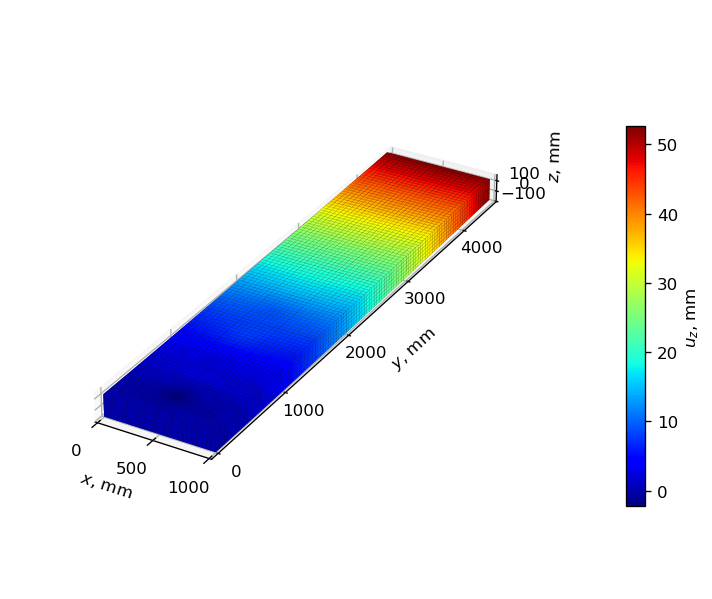

In [15]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot part of the equilibrium paths that should not be visible on top of the plane
path_keys = [0, 2]  # list of the dictionary keys corresponding to the natural and the complementary paths
load_factor = 1.25
for key in path_keys:
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key]<load_factor, nondimensional_applied_loads[key], np.nan),
                 markers[key], color=colors[key])

# Plot plane
local_displacements_array = np.concatenate(tuple(nondimensional_local_displacements[key] for key in path_keys))
tip_displacements_array = np.concatenate(tuple(nondimensional_tip_displacements[key] for key in path_keys))
xx, yy = np.meshgrid([np.min(local_displacements_array), np.max(local_displacements_array)], [np.min(tip_displacements_array),
                                                                                              np.max(tip_displacements_array)])
ax_3d.plot_surface(xx, yy, np.full_like(xx, load_factor), alpha=0.4, color=colors[len(nondimensional_local_displacements)])

# Plot part of the equilibrium paths that should be visible on top of the plane
for key in path_keys:
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key]>=load_factor, nondimensional_applied_loads[key], np.nan),
                 markers[key], color=colors[key], zorder=3)

# Set plot appearance
ax_3d.set_xlabel(f'$u_{{z, {max_displacement_node_id:d}}}/l$')
ax_3d.set_ylabel('$u_{z, tip}/l$')
ax_3d.set_zlabel('$P/P_\mathrm{SOL\/105}$')
ax_3d.grid(visible=True)
plt.show()

# Plot static deformation of natural path
print('Deformation on natural path:')
key = 0
analysis_label = "2Psol105_epsp1e-3"
load_step = np.argmin(np.abs(nondimensional_applied_loads[key] - load_factor)) + 1  # find closest load step to plane
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[analysis_label], subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

# Plot first deformation on unstable path
print('Deformations on unstable path:')
key = 2
analysis_label = "2Psol105_epsp1e-3_modified_load_desiter2"
negative_displacements_indices = np.where(nondimensional_local_displacements[key] < 0)[0]
load_step = negative_displacements_indices[np.argmin(
    np.abs(nondimensional_applied_loads[key][negative_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[analysis_label], subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

# Plot second deformation on unstable path
positive_displacements_indices = np.where(nondimensional_local_displacements[key] > 0)[0]
load_step = positive_displacements_indices[np.argmin(
    np.abs(nondimensional_applied_loads[key][positive_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2[analysis_label], subcase_id=second_subcase_id,
                                                      load_step=load_step, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

These results clearly show that the equilibrium paths describe different deformation states.

We conclude the investigation of the equilibrium paths here, as the objective of this notebook is not to perform an exhaustive study on all the complementary paths of the box beam reinforced with ribs and stiffeners, but rather to give an impression of how those look like. 

## Conclusions <a name="conclusions"></a>

***

In this notebook we have verified the existence of another equilibrium path of the box beam reinforced with ribs and stiffeners. More specifically, we were able to find a complementary path that was partly unstable and partly stable, and disconnected from the natural path. Similarly to our last notebooks, this was possible by choosing very coarse arc-length and by playing around with the convergence tolerances of the nonlinear analysis. The same caveats and reflections apply here as well. In addition, we noticed that, with the inclusion of the stiffeners in the structure, we needed a smaller arc-length size to track the complementary path when unloading the structure in comparison to the previous notebooks. This may indicate that as the structure becomes more complicated, the equilibrium manifold becomes more crowded, and as a consequence the arc-length solver becomes more sensitive to jumping between paths and it needs a smaller step size.